In [1]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from collections import defaultdict
from nltk.stem import PorterStemmer

In [2]:
# nltk.download('twitter_samples')
# nltk.download('stopwords')
# we need to download it just once!

## read tweets

In [3]:
# get the sets of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# avoid assumptions about the length of all_positive_tweets
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

### clean tweets

In [4]:
nltk_stopwords = stopwords.words('english')
my_stopwords = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
                "you", "your", "yours", "yourself", "yourselves", "he", "him",
                "his", "himself", "she", "her", "hers", "herself", "it", "its",
                "itself", "they", "them", "their", "theirs", "themselves", "what",
                "which", "who", "whom", "this", "that", "these", "those", "am", "is",
                "are", "was", "were", "be", "been", "being", "have", "has", "had",
                "having", "do", "does", "did", "doing", "a", "an", "the", "and",
                "but", "if", "or", "because", "as", "until", "while", "of", "at",
                "by", "for", "with", "about", "against", "between", "into", "through",
                "during", "before", "after", "above", "below", "to", "from", "up",
                "down", "in", "out", "on", "off", "over", "under", "again", "further",
                "then", "once", "here", "there", "when", "where", "why", "how", "all",
                "any", "both", "each", "few", "more", "most", "other", "some", "such",
                "only", "own", "same", "so", "than", "too", "very",
                "can", "will", "just", "should", "now"}

## Manage emojis

In [5]:
def emoji(tweet):
    tweet = re.sub(r'(:\(?\()' , ':(' , tweet)
    tweet = re.sub(r'(:\(:\()' , ':(' , tweet)
    tweet = re.sub(r'(: \()' , ':(' , tweet)
    
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\)|:-\)|\(:|\(-:|:\'\)|:o)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:d|:-d|x-?d|x-?d)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-) ,:p 
    tweet = re.sub(r'(;-?\)|;-?d|\(-?;|@-\)|:-?p)', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\(|:-\(|\):|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

## Remove stop words

In [6]:
def stop_words(tweet):
    stopwords_english = my_stopwords
    
    # Lower tweets
    tweet = tweet.lower()
    
    # Replace contractoins
    for word in contractions:
        tweet = re.sub( word , contractions[word.lower()], tweet)
    
    # Remove Stopwords
    tweet = ' '.join([word for word in tweet.split() if word not in stopwords_english])
        
    return tweet

## Negation handling

In [7]:
import json
with open('contractions.json', 'r') as f:
   contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

def negation(tweet):
    
    #for word in contractions:
    #    tweet = re.sub( word , contractions[word.lower()], tweet.lower())
    
    tweet = emoji(tweet)                                              # Replaces Emojis

    tokenizer = TweetTokenizer(strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = ""
    flag = 0
    for word in tweet_tokens:
        if(flag == 0):
            if(len(word)>1):
                tweets_clean += word + ' '
                #tweets_clean.append(word)
        if (word == 'not'):
            flag = 1
        if(word == '.' or word == ','):
            flag = 0
        if(flag == 1 and word != 'not'):
            if(len(word)>1):
                tweets_clean += 'not_'+ word + ' '
        
    return tweets_clean 

In [8]:
from nltk.stem.snowball import SnowballStemmer

def process_tweet(tweet):

    tweet = stop_words(tweet)                                          #replace contractions and stop-words
    
    
    tweet = re.sub('@[^\s]+', '', tweet)                               # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)    # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                            # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                                # Remove (&quot;) 
    #tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                          # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                            # Replaces double spaces with single space   
    #tweet = re.sub(r'\$\w*', '', tweet)                               # Remove stock market tickers like $GE
    #tweet = re.sub(r'^RT[\s]+', '', tweet)                            # Remove old style retweet text "RT"
    tweet = re.sub(r'#', '', tweet)                                    # Only removing the hash # sign from the word
    
    tweet = negation(tweet)                                            
    tweet = re.sub(r'\.','',tweet)                                     # Remove dots           
    #stemmer = PorterStemmer()
    stemmer = SnowballStemmer("english")
    
    nltk_stopwords = stopwords.words('english')
    nltk_stopwords2 = []
    for word in nltk_stopwords:
        nltk_stopwords2.append(word)
        nltk_stopwords2.append('not_' + word)
        
    stopwords_english = nltk_stopwords2
    #stopwords_english = my_stopwords
    
    # tokenize tweets
    tokenizer = TweetTokenizer(strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and              # Remove stopwords
                word not in string.punctuation):           # Remove punctuation
            # tweets_clean.append(word)
            clean_word = lemmatizer.lemmatize(word)        # Lemmatize word
            #clean_word = stemmer.stem(word)               # Stemming word
            #clean_word = word
            if(len(clean_word)>1):
                tweets_clean.append(clean_word)   
    
    return tweets_clean

In [9]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

# print cleaned tweet
print(process_tweet(custom_tweet))

['rt', 'hello', 'great', 'day', 'positiveemoji', 'good', 'morning']


In [10]:
def count_tweets(result, tweets, ys):

    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word,y)

            if pair in result:
                result[pair] += 1

            else:
                result[pair] = 1

    return result

In [11]:
freqs = count_tweets({}, train_x, train_y)

tweet = "Thank you for your support :), won't forget http://t.co/ihELksfJjT,@%%*"
tweet = process_tweet(tweet)
print(tweet)
#print(freqs)
for word in tweet:
    print(word , "-> ", "neg_freauency: " , freqs[(word , 0)])
    print(word , "-> ", "pos_freauency: " , freqs[(word , 1)])

['thank', 'support', 'positiveemoji', 'not_forget']
thank ->  neg_freauency:  20
thank ->  pos_freauency:  189
support ->  neg_freauency:  13
support ->  pos_freauency:  22
positiveemoji ->  neg_freauency:  40
positiveemoji ->  pos_freauency:  4013
not_forget ->  neg_freauency:  2
not_forget ->  pos_freauency:  8


## count unique words

In [12]:
vocab = set([pair[0] for pair in freqs.keys()])# some words are in both negative an positive sentences
V = len(freqs)
print(V)

12852


## number of all positive word and negative word with repetition

In [13]:
# calculate N_pos, N_neg, V_pos, V_neg
N_pos = N_neg = V_pos = V_neg = 0
for pair in freqs.keys():
    # if the label is positive (greater than zero)
    if pair[1] > 0:
        # increment the count of unique positive words by 1
        V_pos += 1

        # Increment the number of positive words by the count for this (word, label) pair
        N_pos += freqs[pair]

    # else, the label is negative
    else:
        # increment the count of unique negative words by 1
        V_neg += 1

        # increment the number of negative words by the count for this (word,label) pair
        N_neg += freqs[pair]

## compute log prior. number of positive sentence on number of negative one

In [14]:
#Calculate D, the number of documents
D = len(train_y)

# Calculate D_pos, the number of positive documents
D_pos = (len(list(filter(lambda x: x > 0, train_y))))

# Calculate D_neg, the number of negative documents
D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

# Calculate logprior
logprior = np.log(D_pos) - np.log(D_neg)

## compute logliklihood

In [15]:
def lookup(freqs, word, label):
    n = 0
    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [16]:
loglikelihood = {}
#print(tweet)
#vocab = tweet
#vocab = ["sad"]

for word in vocab:
    # get the positive and negative frequency of the word
    freq_pos = lookup(freqs,word,1)
    freq_neg = lookup(freqs,word,0)

    # calculate the probability that each word is positive, and negative
    p_w_pos = (freq_pos + 1) / (N_pos + V)
    p_w_neg = (freq_neg + 1) / (N_neg + V)

    # calculate the log likelihood of the word
    loglikelihood[word] = np.log(p_w_pos/p_w_neg)
    
print("N_pos= ", N_pos)
print("N_neg= ", N_neg)
print("V= ", V)
print(loglikelihood)

N_pos=  25371
N_neg=  24542
V=  12852
{'incredibleindia': 0.6712200156356743, 'heartbeat': 0.6712200156356743, 'not_indiana': -0.7150743454842162, 'sry': -0.7150743454842162, 'not_ha': 1.3643671961956196, 'sobbing': -0.7150743454842162, 'package': 0.6712200156356743, 'confession': 0.6712200156356743, 'not_ugh': -1.1205394535923807, 'kaya': -1.1205394535923807, 'smiling': 2.4629794848637294, 'العنزي': 0.6712200156356743, 'not_playlist': -0.7150743454842162, 'woohyun': -1.1205394535923807, 'ano': -1.1205394535923807, 'auto-followback': -0.7150743454842162, 'not_brain': 0.6712200156356743, 'shoushitsu': 0.6712200156356743, 'gwinett': 0.6712200156356743, 'wow': 1.0766851237438384, 'daay': 0.6712200156356743, 'freshness': 1.0766851237438386, 'allows': 0.6712200156356743, 'coursee': 0.6712200156356743, 'ng': 0.38353794318389334, 'weak': -0.42739227303243543, 'transparency': -0.7150743454842162, 'not_happier': -0.7150743454842162, 'case': 0.1603943918696834, 'favorable': 0.6712200156356743, '

In [17]:
loglikelihood

{'incredibleindia': 0.6712200156356743,
 'heartbeat': 0.6712200156356743,
 'not_indiana': -0.7150743454842162,
 'sry': -0.7150743454842162,
 'not_ha': 1.3643671961956196,
 'sobbing': -0.7150743454842162,
 'package': 0.6712200156356743,
 'confession': 0.6712200156356743,
 'not_ugh': -1.1205394535923807,
 'kaya': -1.1205394535923807,
 'smiling': 2.4629794848637294,
 'العنزي': 0.6712200156356743,
 'not_playlist': -0.7150743454842162,
 'woohyun': -1.1205394535923807,
 'ano': -1.1205394535923807,
 'auto-followback': -0.7150743454842162,
 'not_brain': 0.6712200156356743,
 'shoushitsu': 0.6712200156356743,
 'gwinett': 0.6712200156356743,
 'wow': 1.0766851237438384,
 'daay': 0.6712200156356743,
 'freshness': 1.0766851237438386,
 'allows': 0.6712200156356743,
 'coursee': 0.6712200156356743,
 'ng': 0.38353794318389334,
 'weak': -0.42739227303243543,
 'transparency': -0.7150743454842162,
 'not_happier': -0.7150743454842162,
 'case': 0.1603943918696834,
 'favorable': 0.6712200156356743,
 'black': 

## prediction

In [18]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    word_l = process_tweet(tweet)
    p = 0
    p += logprior
    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [19]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):

    accuracy = 0  # return this properly
    y_hats = []
    for tweet in test_x:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0

        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1-error
    
    for i in range(len(y_hats)):
        if (y_hats[i] != test_y[i] ):
            print(test_x[i], test_y[i])
            print(process_tweet(test_x[i]))
    
    return y_hats, accuracy


In [20]:
y_pred, accuracy_ = test_naive_bayes(test_x, test_y, logprior, loglikelihood)

kik : qualky808 #kik #kikmenow #milf #like4like #bored #summer #sexysaturday :) http://t.co/8R2Nrl31IC 1.0
['kik', 'qualky', 'kik', 'kikmenow', 'milf', 'like', 'like', 'bored', 'summer', 'sexysaturday', 'positiveemoji']
@MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p 1.0
['not_sure', 'not_would', 'not_good', 'not_thing', 'not_bottom', 'not_daring', 'not_say', 'not_miss', 'not_im', 'not_gonna', 'not_stubborn', 'not_mouth', 'not_soaping', 'not_nothavingit', 'not_positiveemoji']
It's not like it hurt my feelings or anything right?? :)))))))))))) 1.0
['not_like', 'not_hurt', 'not_feelings', 'not_anything', 'not_right', 'not_positiveemoji']
I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at 11 o'clock last night or if it's a reaction to my meds :) 1.0
['woke', 'feel', 'incredibly', 'sick', 'idk', 'cause', 'drank', 'starbucks', 'clock', 'last', 'night', 'reaction', 'med'

In [21]:
print(f"Naive bayes model's accuracy = {accuracy_:.4f}")

Naive bayes model's accuracy = 0.9895


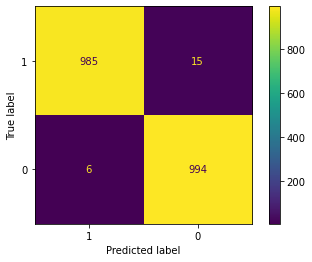

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, y_pred, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,0])
disp.plot()
plt.show()

In [23]:
from sklearn.metrics import f1_score
print("F1_Score: ", f1_score(test_y, y_pred, average=None))

from sklearn.metrics import precision_score
print("precision_score: ", precision_score(test_y, y_pred, average=None,zero_division=1))

from sklearn.metrics import recall_score
print("recall_score:", recall_score(test_y, y_pred, average=None, zero_division=1))

from sklearn.metrics import matthews_corrcoef
print("matthews_corrcoef:" , matthews_corrcoef(test_y, y_pred) )

from sklearn.metrics import log_loss
print("log_loss:" , log_loss(test_y, y_pred) )

F1_Score:  [0.98954704 0.98945254]
precision_score:  [0.9851338  0.99394551]
recall_score: [0.994 0.985]
matthews_corrcoef: 0.9790396519088697
log_loss: 0.3626595509388536
